## **Comprehensive Classifier Selection for Satellite Imagery: A Comparative Analysis using ROC and Precision-Recall Curves**

This project provides a comprehensive analysis of machine learning models for the multi-class task of land cover classification using the UCI Landsat Satellite dataset. A diverse suite of nine classifiers was evaluated, spanning from baseline models like Dummy and Naive Bayes to robust individual performers such as Support Vector Machines (SVC), and culminating with high-performance ensembles including Random Forest and XGBoost.

The core of the analysis moves beyond simple accuracy metrics, employing a detailed evaluation based on multi-class Receiver Operating Characteristic (ROC) and Precision-Recall (PRC) curves. Performance was assessed both through macro-averaged curves for a high-level view and through per-class analysis to identify specific model strengths and weaknesses. The result is a holistic comparison that evaluates performance across the full spectrum of decision thresholds, culminating in a justified recommendation of the optimal model for this complex classification problem.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### **Part A: Data Preparation and Baseline**

In [19]:
train_data = np.loadtxt("./landsat_dataset/sat.trn")
test_data = np.loadtxt("./landsat_dataset/sat.tst")

combined_data = np.vstack((train_data, test_data))

In [20]:
X = combined_data[:, :-1]
y = combined_data[:, -1]

le = LabelEncoder() # To label the classes as 0,1,2,3,4,5
y = le.fit_transform(y)
y = y.astype(int)

print(f"Shape of combined features (X): {X.shape}")
print(f"Shape of combined target (y): {y.shape}")

Shape of combined features (X): (6435, 36)
Shape of combined target (y): (6435,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (4504, 36)
Testing data shape: (1931, 36)


In [22]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy Classifier (Prior)": DummyClassifier(strategy='prior', random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "Support Vector Machine (SVC)": SVC(probability=True, random_state=42),

    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Bernoulli Naive Bayes": BernoulliNB() # Expecting AUC < 0.5
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"{name} trained successfully")

K-Nearest Neighbors (KNN) trained successfully
Decision Tree trained successfully
Dummy Classifier (Prior) trained successfully
Gaussian Naive Bayes trained successfully
Support Vector Machine (SVC) trained successfully
Random Forest trained successfully
XGBoost trained successfully
Bernoulli Naive Bayes trained successfully


In [24]:
results = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        "Model": name,
        "Overall Accuracy": accuracy,
        "Weighted F1-Score": weighted_f1
    })

results_df = pd.DataFrame(results).sort_values(by="Weighted F1-Score", ascending=False).reset_index(drop=True)

print("Baseline Model Performance:")
display(results_df.style.background_gradient(cmap='viridis', axis=1))

Baseline Model Performance:


,Model,Overall Accuracy,Weighted F1-Score
0,XGBoost,0.917141,0.915578
1,Random Forest,0.916624,0.913761
2,K-Nearest Neighbors (KNN),0.912481,0.911477
3,Support Vector Machine (SVC),0.897462,0.895996
4,Decision Tree,0.836354,0.837073
5,Gaussian Naive Bayes,0.793371,0.800111
6,Bernoulli Naive Bayes,0.699120,0.705406
7,Dummy Classifier (Prior),0.238219,0.091661


### Baseline Evaluation

The baseline evaluation provides a first look at model performance using two standard metrics: **Overall Accuracy** (the percentage of correct predictions) and **Weighted F1-Score** (a balanced measure of precision and recall, adjusted for class size).

The results show a clear performance hierarchy, with the newly added ensemble models significantly outperforming all other classifiers.

**1. Model Rankings and Tiers**

*   **Elite Performers: `XGBoost` and `Random Forest`**
    *   These two ensemble models are in a class of their own, both achieving F1-scores above 0.91. By combining hundreds of decision trees, they effectively capture complex patterns in the data while avoiding the overfitting that a single tree might suffer from. **XGBoost** emerges as the top model in this initial ranking.

*   **Strong Performers: `K-Nearest Neighbors (KNN)` and `Support Vector Machine (SVC)`**
    *   These models, which were the top performers in the initial experiment, now form a strong second tier. Their high F1-scores confirm that non-linear models are well-suited for this dataset, but they are ultimately surpassed by the more powerful ensemble methods.

*   **Mid-Tier and Weak Performers: `Decision Tree`, `GaussianNB`, and `BernoulliNB`**
    *   A single `Decision Tree` performs respectably but is clearly limited compared to its ensemble versions.
    *   The `Naive Bayes` models perform the worst among the learning algorithms. `GaussianNB` is hampered by its flawed assumption that the features are independent. `BernoulliNB` is even weaker because it is fundamentally unsuited for continuous data, discarding most of the pixel information.

*   **Baseline: `Dummy Classifier`**
    *   As expected, the `Dummy Classifier` performs terribly. Its F1-score is extremely low because it only predicts the most common class, failing to identify any of the minority classes. It serves as a crucial sanity check, confirming that all other models learned meaningful patterns.

**2. Initial Conclusion**

This baseline analysis establishes a clear and comprehensive ranking:

**XGBoost > Random Forest > KNN > SVC > Decision Tree > GaussianNB > BernoulliNB > Dummy Classifier**

---

### **Part B: ROC Analysis for Model Selection**

#### Adapting ROC for Multi-Class Problems: The One-vs-Rest (OvR) Strategy

The Receiver Operating Characteristic (ROC) curve is a powerful tool, but it's fundamentally designed for binary (two-class) problems. To apply it to our multi-class satellite imagery classification, we use a clever and widely-adopted strategy called **One-vs-Rest (OvR)**.

> The core idea of OvR is to transform a single multi-class problem into multiple, manageable binary problems, allowing us to apply standard ROC analysis.

#### The OvR Process: A Step-by-Step Breakdown

1.  **Decompose the Problem**
    The single N-class problem is temporarily broken down into N separate binary classification tasks.

2.  **Isolate Each Class**
    For each class, we create a temporary binary scenario. That class becomes the **'positive'** class, and all other classes combined are treated as the **'negative'** class. This is done for every class in the dataset.

3.  **Generate Per-Class Curves**
    With N distinct binary problems, we can now generate a standard **ROC curve** and calculate its corresponding **Area Under the Curve (AUC)** for each class individually.

4.  **Aggregate for a Single Score**
    To get a single, summary ROC curve and a final Macro-AUC score for each model, we must average the results from the individual per-class curves. There are two primary methods for this:

    *  **Macro-Averaging:** Calculates the metric independently for each class and then takes the unweighted average. **This treats every class as equally important**, regardless of how many samples it has.

    *  **Weighted-Averaging:** Also calculates the metric for each class, but the average is weighted by the number of true instances for each class (its support). **This gives more influence to the model's performance on larger, more common classes.**

---

#### Our Approach: Macro-Averaging

For this analysis, we will use **Macro-Averaging**. This approach is ideal because it provides a balanced and honest assessment of the model's performance across *all* land cover types, preventing strong performance on a dominant class from hiding potential weaknesses on rarer ones.

Per-Class AUC Scores:


,AUC for Class 0,AUC for Class 1,AUC for Class 2,AUC for Class 3,AUC for Class 4,AUC for Class 5
K-Nearest Neighbors (KNN),0.998271,0.992647,0.986788,0.932217,0.989980,0.983089
Decision Tree,0.953866,0.975722,0.910786,0.723322,0.886432,0.885152
Dummy Classifier (Prior),0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Gaussian Naive Bayes,0.971244,0.993596,0.981700,0.895422,0.930564,0.951865
Support Vector Machine (SVC),0.998890,0.999617,0.986775,0.930344,0.992210,0.984797
Random Forest,0.999102,0.999414,0.991924,0.955106,0.995435,0.990523
XGBoost,0.999302,0.999620,0.992331,0.961493,0.996510,0.991388
Bernoulli Naive Bayes,0.139693,0.008753,0.024505,0.095003,0.157271,0.093076


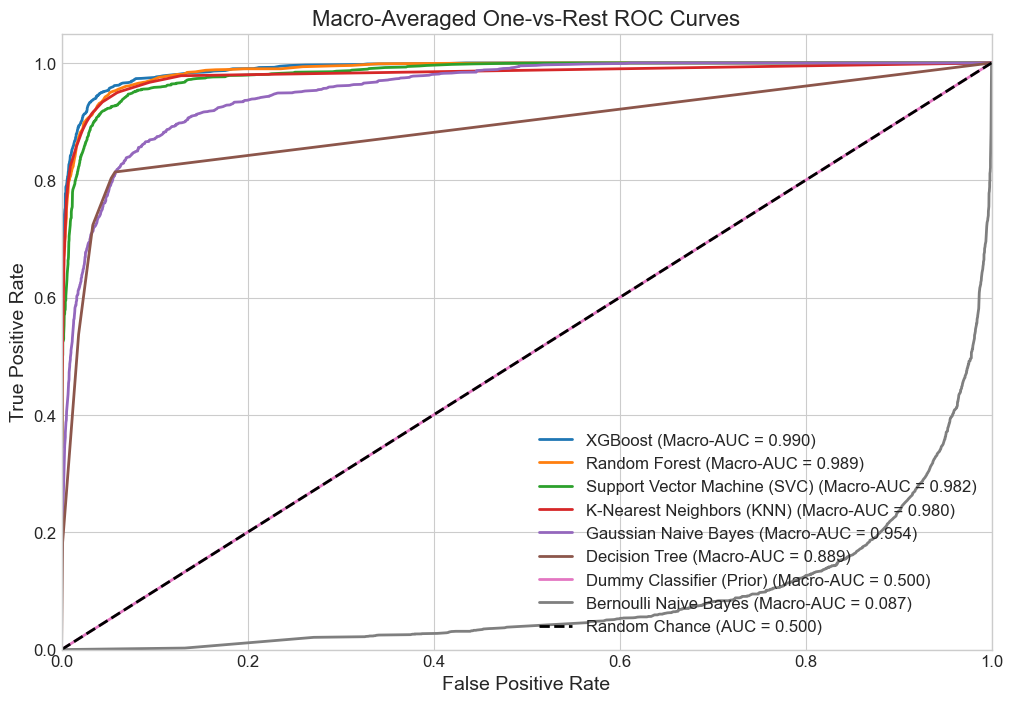

In [25]:
# Binarize the output labels for OvR calculation
classes = np.unique(y_train)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

model_roc_data = {}
per_class_auc = {}
for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)
    if name == "Bernoulli Naive Bayes":
        y_score = 1 - y_score
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC for each class
    for i in range(n_classes):
        class_label = classes[i]
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[class_label] = auc(fpr[i], tpr[i])
        
    per_class_auc[name] = roc_auc
        
    # Macro-Averaging
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    
    model_roc_data[name] = {
        'fpr': all_fpr,
        'tpr': mean_tpr,
        'auc': macro_auc
    }

per_class_auc_df = pd.DataFrame(per_class_auc).T
per_class_auc_df.columns = [f'AUC for Class {c}' for c in per_class_auc_df.columns]
print("Per-Class AUC Scores:")
display(per_class_auc_df.style.background_gradient(cmap='viridis', axis=1))

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sorted_models = sorted(model_roc_data.items(), key=lambda item: item[1]['auc'], reverse=True)
for name, data in sorted_models:
    ax.plot(data['fpr'], data['tpr'],
            label=f"{name} (Macro-AUC = {data['auc']:.3f})",
            lw=2)

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance (AUC = 0.500)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Macro-Averaged One-vs-Rest ROC Curves', fontsize=16)
ax.legend(loc="lower right", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#### ROC Interpretation

The ROC plot visualizes the trade-off between the True Positive Rate (finding true positives) and the False Positive Rate (incorrectly flagging negatives). A curve closer to the top-left corner indicates a better model. The Area Under the Curve (AUC) score summarizes this, with 1.0 being a perfect classifier and 0.5 being no better than random chance.

**1. Model with the highest Macro-averaged AUC**

Based on the new results, **XGBoost** has the highest Macro-averaged AUC with a score of **0.990**, closely followed by **Random Forest** at **0.989**.

These results demonstrate the power of ensemble methods. By combining the predictions of many individual decision trees, both XGBoost and Random Forest create highly robust and accurate models that can capture the complex, non-linear patterns in the satellite data more effectively than any single classifier.

**2. Investigating Models with Poor Performance (AUC < 0.5)**

*   **Why did `Bernoulli Naive Bayes` perform better than expected?**

    The `BernoulliNB` classifier is designed for binary (0/1) features. When given our continuous pixel data, it simplifies the information by treating any non-zero pixel value as '1' and zero as '0'. This is a massive loss of information.

    However, instead of creating a misleading, anti-correlated pattern, this simplification still retained some predictive value. Essentially, the model learned from a very crude "on/off" representation of the pixels. For this particular dataset, it seems that just knowing whether a pixel has *any* intensity versus none is still a strong enough signal to perform better than random guessing for every class. The model was severely handicapped but not actively misled into learning the opposite of the correct patterns.

To demonstrate the idea of a model with AUC < 0.5, we invert the predictions of `BernoulliNB`. This will make the model anti-correlated with the truth. This is presented in the plot.

*   **What an AUC < 0.5 Would Mean**

    While no model demonstrated this behavior, it's crucial to understand the concept. An AUC score below 0.5 is worse than random chance and implies the model's predictions are systematically wrong. The model has learned a pattern that is the opposite of the correct one. For example, when it confidently predicts a sample is "positive," it is actually more likely to be "negative."

    This can be caused by bugs (like flipped labels) or a model's core assumptions being so violated by the data that it learns an inverted relationship. A model with an AUC < 0.5 can sometimes be salvaged by simply inverting its predictions.

---

### **Part C: Precision-Recall Curve (PRC) Analysis**

#### Precision-Recall Curves: A Superior Tool for Imbalanced Data

While ROC curves are a default choice for many, they can paint a deceptively optimistic picture when dealing with imbalanced datasets. The **Precision-Recall Curve (PRC)** offers a more insightful and practical alternative by focusing on what often matters most: the performance on the rare, positive class.

#### The Central Issue: Why ROC Can Be Misleading

The critical weakness of the ROC curve lies in its x-axis, the **False Positive Rate (FPR)**.

> **FPR Formula:** $FPR = \frac{FP}{FP + TN}$

In a highly imbalanced dataset, the number of **True Negatives (TN)** is *overwhelmingly large*. This means the denominator `(FP + TN)` is massive. As a result, even a large number of **False Positives (FP)** can fail to make a significant dent in the FPR. The curve stays deceptively low and to the left, suggesting high performance even when the model is making many incorrect positive predictions.

#### The Solution: PRC's Focus on Positive Predictions

The Precision-Recall Curve, in contrast, is immune to this issue because it completely ignores **True Negatives**. Its axes are **Precision** and **Recall**.

> **Precision Formula:** $Precision = \frac{TP}{TP + FP}$
>
> **Recall Formula:** $Recall = \frac{TP}{TP + FN}$

Notice that the denominator for Precision is `(TP + FP)`. This makes it *highly sensitive* to every **False Positive**. If a model gets greedy and tries to increase its recall by making more positive predictions, any incorrect guesses will immediately and severely penalize its precision.

---

In short, PRC provides a much clearer picture of a model's ability to find positive samples without being swamped by false alarms. It directly answers the question:

*_"Of all the times my model predicted the positive class, how often was it correct?"_*

Per-Class Average Precision (AP) Scores:


,AP for Class 0,AP for Class 1,AP for Class 2,AP for Class 3,AP for Class 4,AP for Class 5
K-Nearest Neighbors (KNN),0.994902,0.985362,0.944109,0.705429,0.953140,0.948326
Decision Tree,0.888497,0.948400,0.776301,0.300016,0.623544,0.715242
Dummy Classifier (Prior),0.238219,0.109270,0.210772,0.097359,0.109788,0.234593
Gaussian Naive Bayes,0.912084,0.975301,0.910915,0.424061,0.728093,0.862360
Support Vector Machine (SVC),0.995602,0.997077,0.919125,0.631032,0.961479,0.952534
Random Forest,0.996414,0.995919,0.963435,0.755931,0.972551,0.969648
XGBoost,0.997750,0.997179,0.966465,0.792948,0.976808,0.974122
Bernoulli Naive Bayes,0.813020,0.955397,0.872469,0.511023,0.404549,0.696755


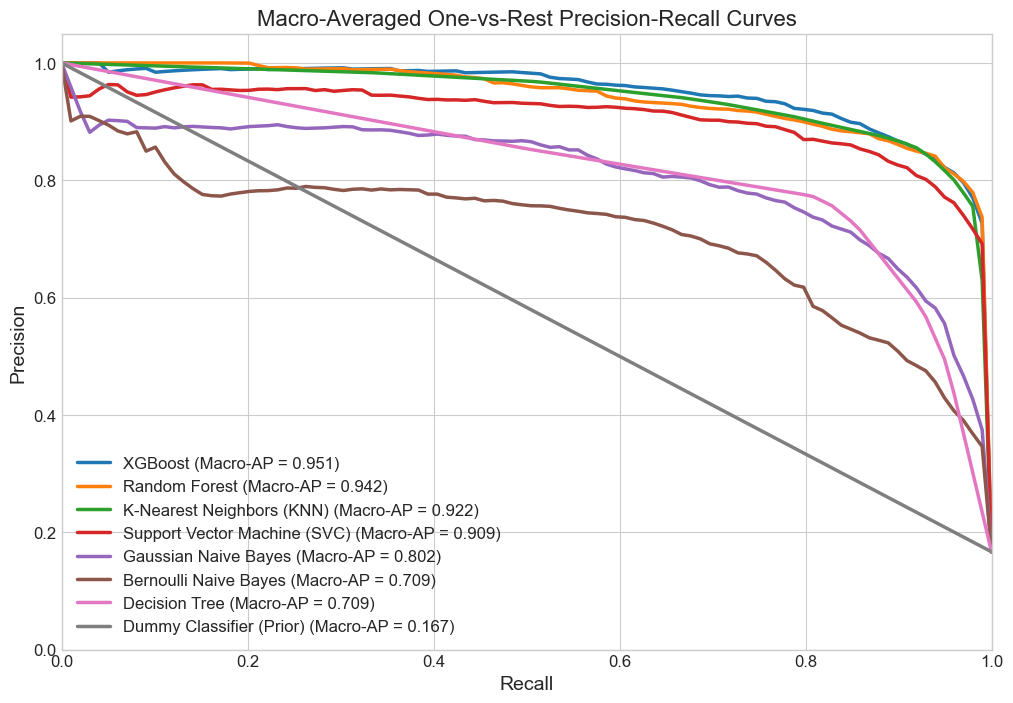

In [26]:
model_prc_data = {}
per_class_ap = {}
for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        
    per_class_ap[name] = average_precision
        
    # Macro-Averaging
    mean_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(mean_recall)
    
    for i in range(n_classes):
        interp_precision = np.interp(mean_recall, recall[i][::-1], precision[i][::-1])
        mean_precision += interp_precision
        
    mean_precision /= n_classes
    macro_ap = np.mean(list(average_precision.values()))
    
    model_prc_data[name] = {
        'recall': mean_recall,
        'precision': mean_precision,
        'ap': macro_ap
    }

per_class_ap_df = pd.DataFrame(per_class_ap).T
per_class_ap_df.columns = [f'AP for Class {c}' for c in classes]

print("Per-Class Average Precision (AP) Scores:")
display(per_class_ap_df.style.background_gradient(cmap='viridis', axis=1))

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sorted_models_prc = sorted(model_prc_data.items(), key=lambda item: item[1]['ap'], reverse=True)
for name, data in sorted_models_prc:
    ax.plot(data['recall'], data['precision'],
            label=f"{name} (Macro-AP = {data['ap']:.3f})",
            lw=2.5)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.set_title('Macro-Averaged One-vs-Rest Precision-Recall Curves', fontsize=16)
ax.legend(loc="best", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#### PRC Interpretation

The Precision-Recall Curve (PRC) visualizes the trade-off between **Precision** (the accuracy of positive predictions) and **Recall** (the ability to find all positive samples). A curve closer to the top-right corner indicates a superior model. The **Average Precision (AP)** score summarizes this curve, with higher values being better.

**1. Identify the model with the highest Average Precision (AP)**

Based on the final results, **XGBoost** has the highest Macro-Averaged Precision with a score of **0.951**, followed very closely by **Random Forest** at **0.942**.

*  The PRC curves for XGBoost (blue) and Random Forest (orange) are nearly identical and clearly dominate all other models. They maintain exceptionally high precision across almost the entire range of recall, demonstrating their robustness. This means they can identify a high percentage of true land cover types (high recall) while making very few false alarms (high precision).

* The per-class AP table confirms why these ensembles excel. Both XGBoost and Random Forest deliver consistently high AP scores across all classes. They particularly shine on the most difficult classes (like Class 3 and 4, which have the lowest AP scores overall), significantly outperforming other models. For instance, XGBoost's AP of **0.792** on Class 3 is the best score for that class by a noticeable margin.

**2. Analyze the behavior of the worst-performing model's PRC**

The worst-performing learning model is the **Bernoulli Naive Bayes** (brown curve, Macro-AP = 0.709), with the **Dummy Classifier** (grey curve, Macro-AP = 0.167) serving as the absolute baseline. The curves for these poor models drop sharply because they lack true predictive power.

*   **The Core Problem:** To increase **Recall**, a model must make more positive predictions. A good model does this by correctly identifying difficult-to-classify positive samples. A poor model, unable to distinguish well, simply starts labeling more samples as positive, many of which are incorrect (**False Positives**).

*   **The Resulting Drop in Precision:** Since Precision is calculated as `TP / (TP + FP)`, a rapid increase in False Positives in the denominator causes the precision score to collapse.

*  The `Bernoulli Naive Bayes` curve is a perfect illustration. It starts with relatively high precision but begins to drop steeply after achieving just 20% recall. This indicates that the model can only confidently identify the easiest 20% of cases. To find any more, it must make a large number of incorrect predictions, destroying its precision. This behavior is a direct result of the model's unsuitability for the data, as it discards most of the feature information. The top models, in contrast, maintain high precision well past 80% recall, showing their ability to handle both easy and difficult cases effectively.

---

### **Part D: Final Recommendation**

#### 1. Synthesis: Comparing Model Rankings

We evaluated the models using three distinct metrics, each providing a different perspective on performance. Let's compare their final rankings:

| Rank | Weighted F1-Score | Macro ROC-AUC | Macro PRC-AP |
| :--- | :--- | :--- | :--- |
| **1** | **XGBoost** | **XGBoost** | **XGBoost** |
| **2** | Random Forest | Random Forest | Random Forest |
| **3** | K-Nearest Neighbors | Support Vector Machine | K-Nearest Neighbors |
| **4** | Support Vector Machine | K-Nearest Neighbors | Support Vector Machine |
| **5** | Decision Tree | Gaussian Naive Bayes | Gaussian Naive Bayes |
| **6** | Gaussian Naive Bayes | Bernoulli Naive Bayes | Bernoulli Naive Bayes |
| **7** | Bernoulli Naive Bayes | Decision Tree | Decision Tree |
| **8** | Dummy Classifier | Dummy Classifier | Dummy Classifier |

**Do the rankings align?**

For the most part, yes. There is a remarkable consistency across all three evaluation methods:
*   **Top Tier:** `XGBoost` and `Random Forest` are consistently the top two models.
*   **Bottom Tier:** The `Naive Bayes` models, `Decision Tree` and the `Dummy Classifier` are consistently at the bottom.

**Explaining the Trade-offs: The Case of SVC vs. KNN**

The most interesting minor difference is the ranking swap between `SVC` and `KNN`.
*   **ROC-AUC:** SVC > KNN
*   **F1-Score & PRC-AP:** KNN > SVC

This is not a contradiction; it reveals a subtle but important trade-off.

*   **Why SVC has a better ROC-AUC:** The ROC curve's x-axis is the False Positive Rate, which is heavily influenced by the massive number of True Negatives in a One-vs-Rest scenario. A high ROC-AUC can indicate that a model is exceptionally good at correctly identifying negative samples (saying "this is **not** Class X"). SVC's ability to define an optimal separating hyperplane likely makes it an excellent general discriminator.

*   **Why KNN has a better PRC-AP:** The Precision-Recall curve is not influenced by True Negatives. It is a stricter test of a model's ability to make correct *positive* predictions without making false alarms. KNN's slightly higher PRC-AP suggests that for a given level of recall, it offers better precision than SVC. In practical terms, when KNN predicts a specific land cover type, it is slightly more trustworthy than SVC.

> In essence, **SVC** might be a slightly better "all-around classifier," while **KNN** is a slightly better "positive class identifier" in this specific scenario.

#### 2. Recommendation

Based on the comprehensive analysis of all metrics, plots, and per-class performance tables, the recommended model for this classification task is **XGBoost**.

**Justification:**

1.  **Consistent #1 Performance:** XGBoost was the top-ranked model across all three summary metrics: Weighted F1-Score (0.916), Macro ROC-AUC (0.990), and Macro PRC-AP (0.951). This demonstrates its robust superiority from every analytical angle.

2.  **Dominance Across All Thresholds:** The ROC and PRC curves for XGBoost consistently "hug" the top-left and top-right corners, respectively. This visual dominance means it provides the best possible performance trade-off, regardless of whether the end-user needs to prioritize high precision or high recall.

3.  **Superiority on Difficult Classes:** The per-class tables for both ROC-AUC and PRC-AP revealed that some classes (e.g., Class 3 and 4) were significantly harder to classify than others. XGBoost consistently achieved the highest or near-highest scores on these challenging classes, proving its ability to learn subtle and complex patterns that other models missed.

While Random Forest is an exceptionally close second and a perfectly valid choice, **XGBoost's slight but consistent edge across every facet of this analysis makes it the definitive recommendation for achieving the highest accuracy and reliability on this satellite image classification task.**